In [824]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('classic')

In [825]:
# this whole section works as input from user
# set up strategy variables
symbol = 'ETH-USD'
start = '2022-02-01'
end = '2023-02-22'
interval = '1h'
fast_sma = 12
slow_sma = 26

# set up stable position size and laverage (if no laverage set up for 1)

laverage = 3
position_size = 1000

[*********************100%***********************]  1 of 1 completed


In [826]:
df = yf.download(symbol, start, end, interval=interval)

,Open,High,Low,Close,Adj Close,Volume
2022-01-31 23:00:00+00:00,2682.983154,2688.123535,2681.151367,2688.123535,2688.123535,0
2022-02-01 00:00:00+00:00,2687.898926,2695.661865,2682.621826,2688.253662,2688.253662,0
2022-02-01 01:00:00+00:00,2689.559814,2697.903564,2684.163818,2686.996094,2686.996094,0
2022-02-01 02:00:00+00:00,2687.045166,2709.399658,2685.692871,2709.399658,2709.399658,0
2022-02-01 03:00:00+00:00,2710.852051,2750.967285,2709.241211,2750.967285,2750.967285,255102976
...,...,...,...,...,...,...
2023-02-21 18:00:00+00:00,1674.325684,1682.198975,1674.325684,1680.110229,1680.110229,120632320
2023-02-21 19:00:00+00:00,1679.993164,1679.993164,1671.905518,1672.815674,1672.815674,0
2023-02-21 20:00:00+00:00,1672.766357,1674.366455,1667.279785,1669.976807,1669.976807,0
2023-02-21 21:00:00+00:00,1669.832397,1670.775757,1655.881958,1655.881958,1655.881958,111041536


In [827]:
df = pd.DataFrame(data=df).reset_index()

In [828]:
df = df[['Open', 'High', 'Low', 'Close']]

In [829]:
df['sma_fast'] = ta.sma(close=df['Close'], length=fast_sma)
df['sma_slow'] = ta.sma(close=df['Close'], length=slow_sma)

In [830]:
df['position'] = np.where(df['sma_fast'] > df['sma_slow'], 1,
                         np.where(df['sma_fast'] < df['sma_slow'], -1, 0))

In [831]:
df['position_price'] = np.where(df['position'].shift(1) != df['position'], df['Close'], 0)

In [832]:
df['position_price'] = df['position_price'].replace(0, df['position_price'], method='ffill')

In [833]:
df['pct'] = 0

In [834]:
df['pct'] = np.where(df['position'].shift(1) == 0, 0, df['position_price'].pct_change())

In [835]:
df['pct'] = np.where(df['position'] == 1, df['pct'] * -1, df['pct'] * 1)

In [836]:
pct_sum = df['pct'].sum()

In [837]:
positions = df.pct[df['pct'] != 0]

In [838]:
positions_df = pd.DataFrame(data=positions)
positions_df.drop(index=0, inplace=True)

In [839]:
q_low = positions_df["pct"].quantile(0.025)
q_hi  = positions_df["pct"].quantile(0.975)

positions_df_filtered = positions_df[(positions_df["pct"] < q_hi) & (positions_df["pct"] > q_low)]
pct_sum_filtered = positions_df_filtered.pct.sum()

In [841]:
positions_df['revenue'] = position_size + (positions_df['pct'] * (position_size * laverage))

In [842]:
revenue_sum = positions_df['revenue'].sum()

In [843]:
positions_number = positions_df['revenue'].count()

In [844]:
total_revenue = revenue_sum - (positions_number * position_size)

In [845]:
# filtered for quantile 2,5% of top and bottom

positions_df_filtered['revenue'] = position_size + (positions_df_filtered['pct'] * (position_size * laverage))
revenue_sum_filtered = positions_df_filtered['revenue'].sum()

positions_number_filtered = positions_df_filtered['revenue'].count()
total_revenue_filtered = revenue_sum_filtered - (positions_number_filtered * position_size)

/var/folders/m4/67l_b9zj1m78cn4x96l_nm2c0000gn/T/ipykernel_2289/276724956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions_df_filtered['revenue'] = position_size + (positions_df_filtered['pct'] * (position_size * laverage))


In [846]:
won_positions = positions_df[positions_df['pct'] > 0]

In [847]:
pct_winning = won_positions['pct'].count() / positions_number

Number of trades: 941

Total revenue of trades 7924.124672940234$
Strategy revenue %: 2.6413748909800874
Strategy % won trades: 0.5334750265674814

After ignoring outliers (2,5% of top and 2,5% of bottom results), total revenue is: 4882.914891320397$
and % of revenue is: 1.6276382971068257


<AxesSubplot:>

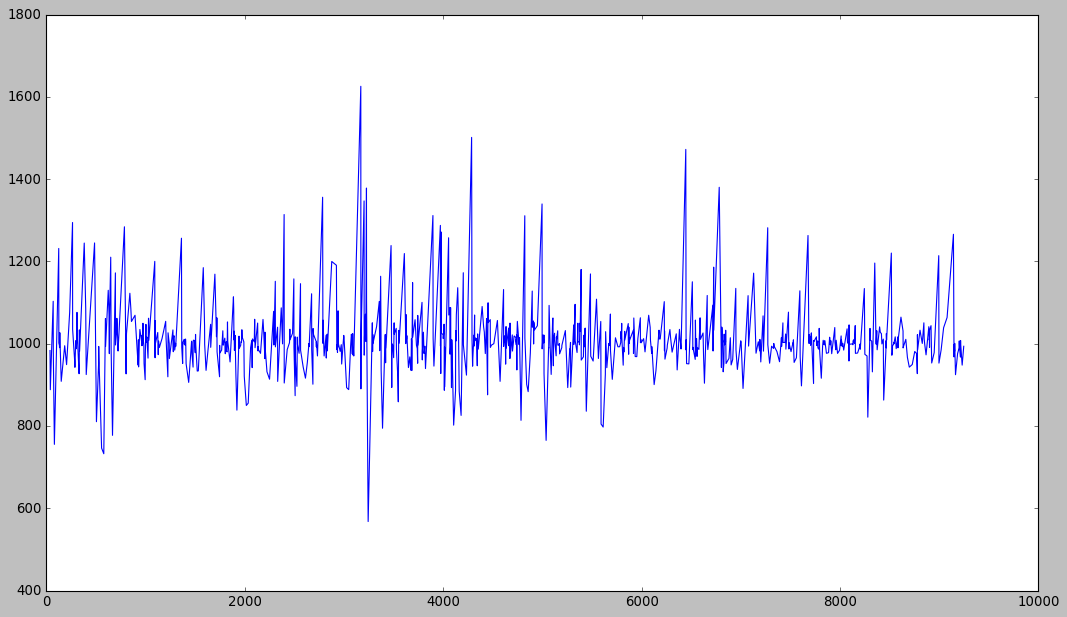

In [849]:
print(f'Number of trades: {positions_number}\n')
print(f'Total revenue of trades {total_revenue}$')
print(f'Strategy revenue %: {pct_sum}')
print(f'Strategy % won trades: {pct_winning}\n')

print(f'After ignoring outliers (2,5% of top and 2,5% of bottom results), total revenue is: {total_revenue_filtered}$')
print(f'and % of revenue is: {pct_sum_filtered}')
positions_df['revenue'].plot(figsize=(16, 9))